# target encoder & ohe & just crossnet

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, dcn, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:10, 55345.24it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 55334.16it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:12, 46492.20it/s]
400000it [00:08, 47106.40it/s]


# Search Max LR

In [ ]:
%%time
%matplotlib inline

mf = {}
for num in [1,2,3,4]:
    batch_size = 8192
    epochs = 5
    nflold = 5

    model_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam',
                   'loss': 'binary_crossentropy', 
                   'use_linear': False, 'use_deep': False, 'num_cross': num}

    mf[num] = MaxLrFinder(1e-5, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
    fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf[num]]}

    model = dcn(**model_param)

    cv = CV(model, nflold)

    score = cv.fit(x=[idx, val],
                   y=y_train, 
                   metrics_func=roc_auc_score,
                   split_method=StratifiedKFold,
                   fit_params=fit_param,
                   eval_param={'batch_size':batch_size},
                   use_proba=False, 
                   verbose=True,
                   fit_use_valid=True)

    tf.keras.backend.clear_session()

In [ ]:
%matplotlib inline
for key, submf in mf.items():
    submf.plot(True, [0.3, 0.8])

# fit one

In [14]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False, 'use_deep': False}

clr = CyclicLR(base_lr=0.1**(3.5),
               max_lr = 0.1**(2.5), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = dcn(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 5s 11us/sample - loss: 0.5616 - AUC: 0.5019 - val_loss: 0.4803 - val_AUC: 0.5936
Epoch 2/100
480000/480000 [==============================] - 4s 9us/sample - loss: 0.4642 - AUC: 0.7017 - val_loss: 0.4385 - val_AUC: 0.7700
Epoch 3/100
480000/480000 [==============================] - 4s 9us/sample - loss: 0.4078 - AUC: 0.7780 - val_loss: 0.3978 - val_AUC: 0.7871
Epoch 4/100
480000/480000 [==============================] - 4s 9us/sample - loss: 0.3927 - AUC: 0.7943 - val_loss: 0.3975 - val_AUC: 0.7863
Epoch 5/100
480000/480000 [==============================] - 4s 9us/sample - loss: 0.3907 - AUC: 0.7964 - val_loss: 0.3971 - val_AUC: 0.7867
Epoch 6/100
480000/480000 [==============================] - 4s 9us/sample - loss: 0.3889 - AUC: 0.7986 - val_loss: 0.3971 - val_AUC: 0.7863
folds 0 is done, score is 0.7871912095569739
Train on 480000 samples, validate on 120000 samples
Epoc

In [15]:
score

0.7870833336135628

# Tuning

In [16]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(3.5),
               max_lr = 0.1**(2.5),
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False}

ss = {
    'loss': (hp.choice, ('binary_crossentropy', 'focal_loss')), 
    'k': (hp.choice, (5, 7, 8, 10)),
    'num_cross': (hp.choice, (1, 2, 3 ,4)),
    'l2_em': (hp.loguniform, (-20, 0)),
    'l2_cross': (hp.loguniform, (-20, 0))}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=dcn, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7875, param {'k': 10, 'l2_cross': 6.731590160763889e-05, 'l2_em': 2.6000182551695607e-07, 'loss': 'focal_loss', 'num_cross': 1}
new best, eval 2, score -0.7881, param {'k': 8, 'l2_cross': 1.6718514594660937e-07, 'l2_em': 0.0020174779463484915, 'loss': 'binary_crossentropy', 'num_cross': 4}
new best, eval 5, score -0.7887, param {'k': 7, 'l2_cross': 3.5842697601041923e-09, 'l2_em': 0.00011200174836667317, 'loss': 'focal_loss', 'num_cross': 1}
new best, eval 40, score -0.7887, param {'k': 7, 'l2_cross': 0.0003099378753371395, 'l2_em': 4.676610753140845e-05, 'loss': 'focal_loss', 'num_cross': 2}
100%|██████████| 100/100 [19:20:46<00:00, 696.47s/trial, best loss: -0.7887201469762435]  


{'k': 1,
 'l2_cross': 0.0003099378753371395,
 'l2_em': 4.676610753140845e-05,
 'loss': 1,
 'num_cross': 1}

In [17]:
log = tuning.log.get_log()

In [18]:
log.sort_values('score').head(20)

,score,update,usetime,k,l2_cross,l2_em,loss,num_cross
39,-0.788720,True,642.776856,7,3.099379e-04,0.000047,focal_loss,2
4,-0.788701,True,534.212677,7,3.584270e-09,0.000112,focal_loss,1
19,-0.788686,False,2157.797287,7,2.386235e-01,0.000215,binary_crossentropy,3
57,-0.788674,False,646.401888,7,1.069245e-04,0.000086,focal_loss,1
79,-0.788652,False,1381.528973,7,3.023904e-02,0.000014,focal_loss,4
41,-0.788647,False,515.181068,10,1.922303e-05,0.000050,focal_loss,2
99,-0.788647,False,487.001348,7,2.257474e-05,0.000085,focal_loss,2
7,-0.788626,False,742.756248,8,1.127948e-02,0.000005,focal_loss,3
26,-0.788625,False,667.045235,7,8.183936e-01,0.000026,focal_loss,1
65,-0.788620,False,1031.152227,7,2.985190e-01,0.000058,binary_crossentropy,3


In [19]:
log.sort_values('score').tail(20)

,score,update,usetime,k,l2_cross,l2_em,loss,num_cross
78,-0.786271,False,4267.591210,10,7.237794e-02,0.000196,focal_loss,3
87,-0.783165,False,1487.805371,7,1.043512e-03,0.000448,focal_loss,1
46,-0.781142,False,1778.612037,10,4.579206e-09,0.013439,focal_loss,4
13,-0.780085,False,4327.061211,8,4.705919e-02,0.000544,focal_loss,4
73,-0.779994,False,1245.735508,7,7.068079e-04,0.060357,binary_crossentropy,2
76,-0.762287,False,963.323565,7,2.552766e-09,0.423255,binary_crossentropy,2
28,-0.761625,False,3140.852854,7,9.129405e-03,0.009485,focal_loss,3
66,-0.754576,False,1410.045796,7,1.195319e-01,0.005349,binary_crossentropy,3
6,-0.742954,False,1322.829676,10,1.092750e-08,0.113839,binary_crossentropy,1
8,-0.734888,False,1407.348562,10,1.047765e-01,0.026577,binary_crossentropy,2


[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]


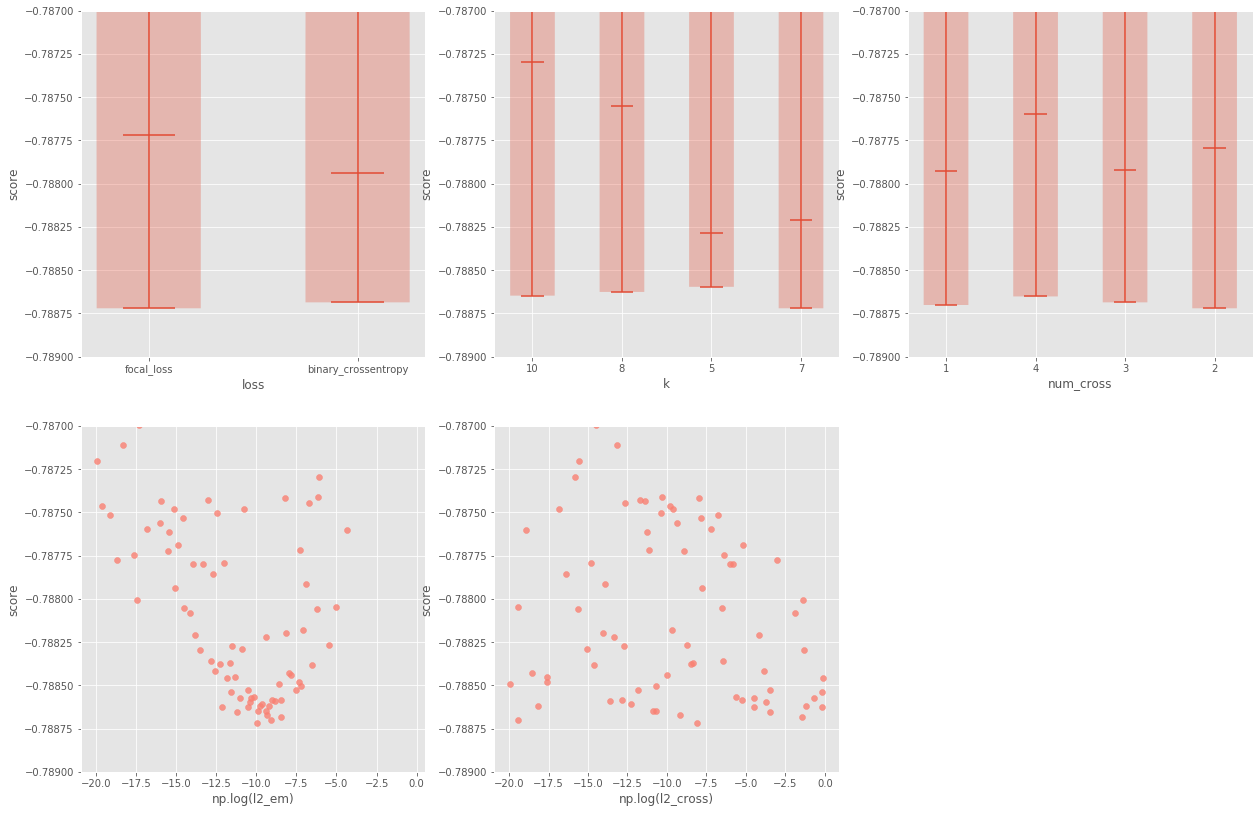

In [23]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.789, -0.787])

In [24]:
np.random.randint(2**32)

2072349059

### 2072349059

In [25]:
! mkdir ../tmp/cross

In [26]:
log.to_csv('../tmp/cross/2072349059.csv', index=False)

In [27]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [28]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False}

In [31]:
# callbacks
clr = CyclicLR(
    base_lr=1e-4,
    max_lr = 0.1**(2.5), 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

# Stacking 1

In [32]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = dcn(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    tf.keras.backend.clear_session()

folds 0 is done, score is 0.7813204393287645
folds 1 is done, score is 0.7906185183549439
folds 2 is done, score is 0.7913090516129394
folds 3 is done, score is 0.787472466883146
folds 4 is done, score is 0.7918050478899807
folds 5 is done, score is 0.7906592659658195
folds 6 is done, score is 0.7900377115487434
folds 7 is done, score is 0.7896053049124736
folds 8 is done, score is 0.7884874767256658
folds 9 is done, score is 0.7838127764411393
folds 10 is done, score is 0.7882994097058648
folds 11 is done, score is 0.8001753666175009
folds 12 is done, score is 0.7867653570881098
folds 13 is done, score is 0.7910319386492287
folds 14 is done, score is 0.7861726911206077
folds 15 is done, score is 0.7898991112522527
folds 16 is done, score is 0.7903769536653806
folds 17 is done, score is 0.7923012632401986
folds 18 is done, score is 0.7943165027882465
folds 19 is done, score is 0.7950614392184684
folds 20 is done, score is 0.7883616410929404
folds 21 is done, score is 0.7865222004667953

folds 18 is done, score is 0.7947813760693109
folds 19 is done, score is 0.7944207670155012
folds 20 is done, score is 0.7884716450374257
folds 21 is done, score is 0.786025327897047
folds 22 is done, score is 0.7866580258363804
folds 23 is done, score is 0.7846585157424231
folds 24 is done, score is 0.7826920856981552
folds 25 is done, score is 0.7880071076685661
folds 26 is done, score is 0.7950612201452917
folds 27 is done, score is 0.7808431226912608
folds 28 is done, score is 0.7963128582284587
folds 29 is done, score is 0.7870636617304515
folds 30 is done, score is 0.7897420503894012
folds 31 is done, score is 0.7889160276740248
folds 32 is done, score is 0.7881908370394672
folds 33 is done, score is 0.7912785712316143
folds 34 is done, score is 0.793061695446456
folds 35 is done, score is 0.79306533206119
folds 36 is done, score is 0.7849388563842714
folds 37 is done, score is 0.783113671417023
folds 38 is done, score is 0.7906553746601025
folds 39 is done, score is 0.7834438994

In [33]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save('../tmp/cross/2072349059stacking1.npy', pred_arr)
pred_arr.shape

(600000, 5)

In [34]:
pred = np.array(pred_lst).squeeze().T
np.save('../tmp/cross/2072349059predict.npy', pred)
pred.shape

(400000, 5)

In [35]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv('../tmp/submission/main_5_crossnet_2072349059.csv')